In [1]:
# imports
import gymnasium as gym
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import defaultdict
import rldurham as rld

In [2]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# import the frozen lake gym environment
name = 'FrozenLake-v1'
env = rld.make(name, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!
rld.seed_everything(42, env)

Seed set to 42


(42, 0, {'prob': 1})

**TD(0) prediction**

In [3]:
num_episodes = 10000
alpha = 0.2
gamma = 1.0
V = np.zeros([env.observation_space.n])

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    while (True):
        a = np.ones(env.action_space.n, dtype=float) / env.action_space.n # random policy
        a = np.random.choice(len(a), p=a)
        next_s, reward, term, trun, _ = env.step(a)
        done = term or trun
        V[s] += alpha * (reward + gamma * V[next_s] - V[s])
        if done: break
        s = next_s

...this is just prediction, it doesn't solve the control problem - let's plot the policy learned from all this random walking

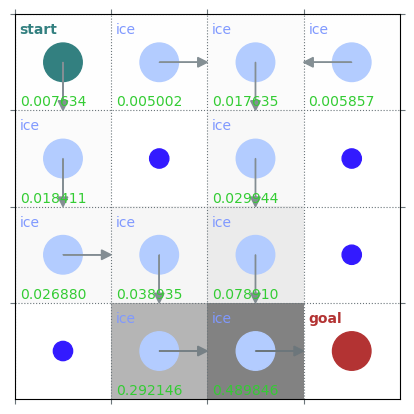

In [4]:
# helper code to plot the policy greedily obtained from TD(0) - ignore this!
policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n
for s in range(env.observation_space.n):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    best_a = np.argwhere(q==np.max(q)).flatten()
    policy[s] = np.sum([np.eye(env.action_space.n)[i] for i in best_a], axis=0)/len(best_a)
rld.plot_frozenlake(env=env, v=V, policy=policy, draw_vals=True)

...the policy is note too bad after one greedy policy step, but it's not perfect - we really need to do control

**On-Policy SARSA TD control** - warning! sometimes this doesn't converge! run it a few times...

In [5]:
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    A[best_action] += (1.0 - epsilon)
    return A

In [6]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
    a = np.random.choice(np.arange(len(p_a)), p=p_a)
    for t in itertools.count():
        next_s, reward, term, trun, _ = env.step(a)
        done = term or trun
        p_next_a = random_epsilon_greedy_policy(Q,epsilon, next_s, env.action_space.n)
        next_a   = np.random.choice(np.arange(len(p_next_a)), p=p_next_a)
        Q[s][a] += alpha * (reward + gamma*Q[next_s][next_a] - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if done: break
        s = next_s
        a = next_a

    if episode % 1000 == 0 and episode != 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()

episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


Text(0, 0.5, 'reward (smoothed)')

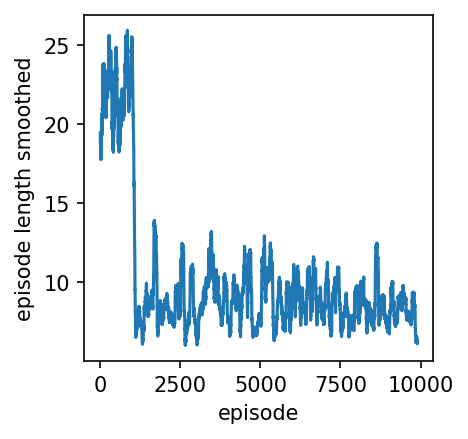

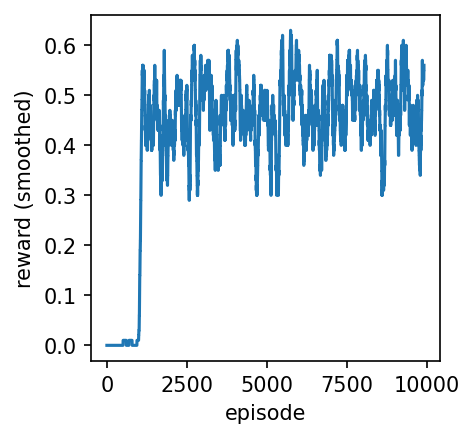

In [7]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')

In [8]:
def pi_star_from_Q(Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, _ = env.reset() # start in top-left, = 0
    while not done:
        action = np.argmax(Q[state, :])
        pi_star[state,action] = 1
        state, reward, term, trun, _ = env.step(action)
        done = term or trun
    return pi_star

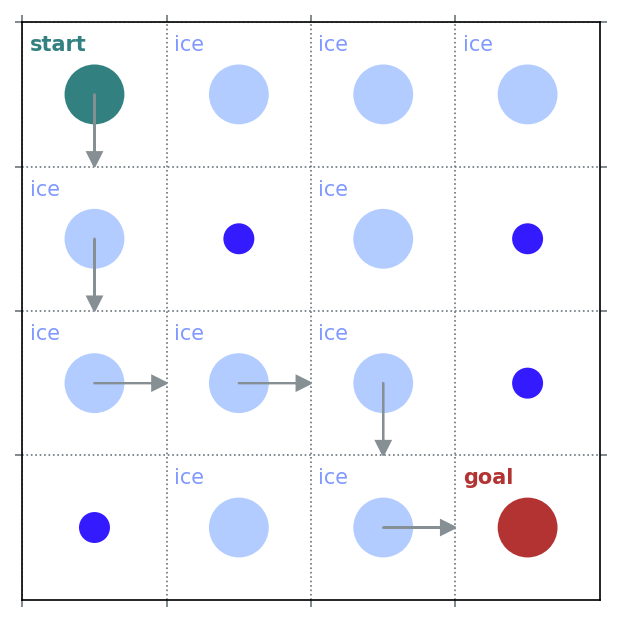

In [9]:
rld.plot_frozenlake(env=env, policy=pi_star_from_Q(Q))

**Off-policy Q-learning TD Control** - warning! sometimes this doesn't converge! run it a few times...

In [10]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
num_episodes = 10000
gamma = 1.0
epsilon = 0.4
alpha = 0.2
stats_rewards = defaultdict(float)
stats_lengths = defaultdict(float)

for episode in range(1,num_episodes+1):
    s, _ = env.reset()
    for t in itertools.count():
        p_a = random_epsilon_greedy_policy(Q, epsilon, s, env.action_space.n)
        a   = np.random.choice(np.arange(len(p_a)), p=p_a)
        next_s, reward, term, trun, _ = env.step(a)
        done = term or trun
        Q[s][a] += alpha * (reward + gamma*np.max(Q[next_s][:]) - Q[s][a])

        stats_rewards[episode] += reward
        stats_lengths[episode] = t
        if done: break
        s = next_s

    if episode % 1000 == 0 and episode != 0:
        print(f"episode: {episode}/{num_episodes}")

print(f"episode: {episode}/{num_episodes}")

env.close()

episode: 1000/10000
episode: 2000/10000
episode: 3000/10000
episode: 4000/10000
episode: 5000/10000
episode: 6000/10000
episode: 7000/10000
episode: 8000/10000
episode: 9000/10000
episode: 10000/10000
episode: 10000/10000


Text(0, 0.5, 'reward (smoothed)')

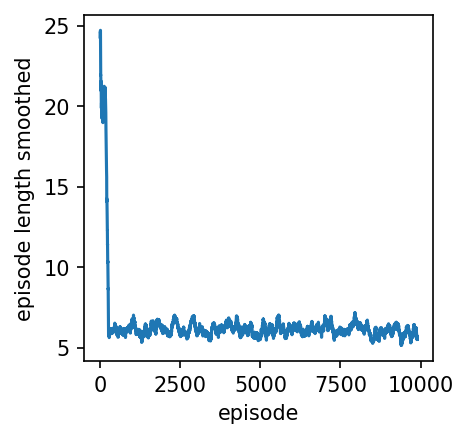

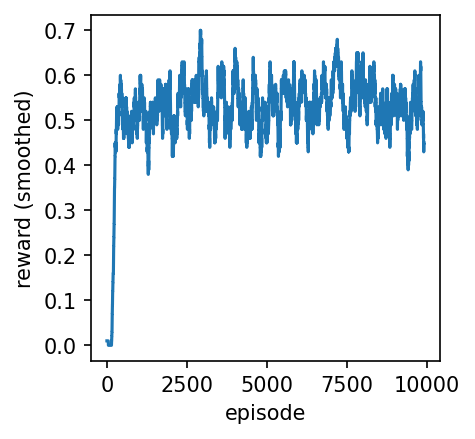

In [11]:
# plot the results
smoothed_lengths = moving_average(np.array(list(stats_lengths.values())))

plt.rcParams['figure.dpi'] = 150

plt.figure(1, figsize=(3,3))
plt.plot(smoothed_lengths)
plt.xlabel('episode')
plt.ylabel('episode length smoothed')

smoothed_rewards = moving_average(np.array(list(stats_rewards.values())))
plt.figure(2, figsize=(3,3))
plt.plot(smoothed_rewards)
plt.xlabel('episode')
plt.ylabel('reward (smoothed)')